### Importing Data Files from Google Earth Engine and NASA 
This notebook imports .tif files exported from google earth engine, and the GFWD (for the month of December) from NASA's Archives. It scales data to the same dimensions, assigns lat and lon coordinates, and exports the consolidated dataset as a pandas dataframe parquet file. 

In [117]:
import pandas as pd
import numpy as np
import xarray as xr
import rasterio as rio
from affine import Affine
import xarray as xr
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import georasters as gr
import geopandas
from rastertodataframe import raster_to_dataframe
import os
from glob import glob
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
%run ../pyfiles/data_cleaning.py

### Set data paths associated with time period to paths. Then run notebook to merge

In [118]:
# Data paths
# CRS.from_epsg(4326)
fire = '../../finalproj_data/data_dec/fire_final.tif' #float32
air = '../../finalproj_data/data_dec/air.tif' #float32
precip = '../../finalproj_data/data_dec/precip_final.tif' #float32
burn = '../../finalproj_data/data_dec/burned_nov.tif' #float32

In [119]:
# # Use this code to check datatype of bands in each file
# {i: dtype for i, dtype in zip(veg.indexes, veg.dtypes)}

In [120]:
# Read file into rasterio
fire = rio.open(fire)
air = rio.open(air)
precip = rio.open(precip)
burned = rio.open(burn)

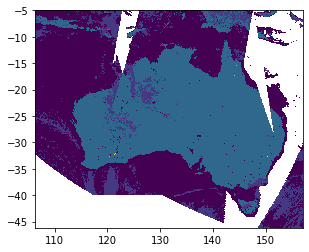

In [121]:
show(fire)

In [122]:
# fire.meta #count shows the number of bands

In [123]:
# get shapes of all the bands from different datasets
fire_shape = list(fire.read(1).shape)
precip_shape = list(precip.read(1).shape)
air_shape = list(air.read(1).shape)
burned_shape = list(burned.read(1).shape)

In [124]:
fire_shape, burned_shape

([917, 1128], [917, 1128])

In [125]:
# info from google earth engine
# scale factors are calculated as a proportion of the dimensions of the fire dataset

fire_bands = ['FireMask', 'MaxFRP', 'QA', 'sample']
a, b = fire_shape[0], fire_shape[1]

# Vegetation bands were not deemed important features after RF classification - dropped this dataset. 
# veg_bands = ['EVI', 'EVI2', 'NVDI','NIR_reflectance', 'SWIR1_reflectance', 
#              'SWIR2_reflectance', 'SWIR3_reflectance', 'VI_Quality', 'blue_reflectance',
#             'composite_day_of_the_year', 'green_reflectance', 'pixel_reliability',
#             'red_reflectance','relative_azimuth_angle','sun_zenith_angle','view_zenith_angle']
# veg_scale_factors = (a/veg_shape[0], b/veg_shape[1])

precip_bands = ['gaugeQualityInfo', 'hourlyPrecipRate', 'hourlyPrecipRateGC', 'observationTimeFlag', 'satelliteInfoFlag']
precip_scale_factors = (a/precip_shape[0], b/precip_shape[1])

air_bands = ['Albedo_inst', 'AvgSurfT_inst', 'CanopInt_inst', 'ECanop_tavg','ESoil_tavg', 'Evap_tavg', 'LWdown_f_tavg',
'Lwnet_tavg', 'PotEvap_tavg', 'Psurf_f_inst', 'Qair_f_inst', 'Qg_tavg', 'Qh_tavg', 'Qle_tavg', 
'Qs_acc', 'Qsb_acc', 'Qsm_acc', 'Rainf_f_tavg', 'Rainf_tavg', 'RootMoist_inst', 'SWE_inst',
'SWdown_f_tavg', 'SnowDepth_inst', 'Snowf_tavg', 'SoilMoi0_10cm_inst', 'SoilMoi100_200cm_inst',
'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilTMP0_10cm_inst', 'SoilTMP100_200cm_inst',
'SoilTMP10_40cm_inst', 'SoilTMP40_100cm_inst', 'Swnet_tavg', 'Tair_f_inst', 'Tveg_tavg', 'Wind_f_inst']
air_scale_factors = (a/air_shape[0], b/air_shape[1])

burned_bands = ['BurnDate', 'Uncertainty', 'QA', 'FirstDay', 'LastDay']
burned_scale_factors = (a/burned_shape[0], b/burned_shape[1])

In [126]:
# Save bands as separate arrays and scale to appropriate dimensions
FireMask = fire.read(1)
MaxFRP = fire.read(2)

# EVI = scale_variable(veg.read(1), veg_scale_factors)
# EVI2 = scale_variable(veg.read(2), veg_scale_factors)
# NVDI = scale_variable(veg.read(3), veg_scale_factors)
# NIR_reflectance = scale_variable(veg.read(4), veg_scale_factors)
# SWIR1_reflectance = scale_variable(veg.read(5), veg_scale_factors)
# SWIR2_reflectance = scale_variable(veg.read(6), veg_scale_factors)
# SWIR3_reflectance = scale_variable(veg.read(7), veg_scale_factors)
# VI_Quality = scale_variable(veg.read(8), veg_scale_factors)
# blue_reflectance = scale_variable(veg.read(9), veg_scale_factors)
# composite_day_of_the_year = scale_variable(veg.read(10), veg_scale_factors)
# green_reflectance = scale_variable(veg.read(11), veg_scale_factors)
# pixel_reliability = scale_variable(veg.read(12), veg_scale_factors)
# red_reflectance = scale_variable(veg.read(13), veg_scale_factors)
# relative_azimuth_angle = scale_variable(veg.read(14), veg_scale_factors)
# sun_zenith_angle = scale_variable(veg.read(15), veg_scale_factors)
# view_zenith_angle = scale_variable(veg.read(16), veg_scale_factors)

gaugeQualityInfo = scale_variable(precip.read(1), precip_scale_factors)
hourlyPrecipRate = scale_variable(precip.read(2), precip_scale_factors)
hourlyPrecipRateGC = scale_variable(precip.read(3), precip_scale_factors)
observationTimeFlag = scale_variable(precip.read(4), precip_scale_factors)
satelliteInfoFlag = scale_variable(precip.read(5), precip_scale_factors)

Albedo_inst = scale_variable(air.read(1), air_scale_factors)
AvgSurfT_inst = scale_variable(air.read(2), air_scale_factors)
CanopInt_inst = scale_variable(air.read(3), air_scale_factors)
ECanop_tavg = scale_variable(air.read(4), air_scale_factors)
ESoil_tavg = scale_variable(air.read(5), air_scale_factors)
Evap_tavg = scale_variable(air.read(6), air_scale_factors)
LWdown_f_tavg = scale_variable(air.read(7), air_scale_factors)
Lwnet_tavg = scale_variable(air.read(8), air_scale_factors)
PotEvap_tavg = scale_variable(air.read(9), air_scale_factors)
Psurf_f_inst = scale_variable(air.read(10), air_scale_factors)
Qair_f_inst = scale_variable(air.read(11), air_scale_factors)
Qg_tavg = scale_variable(air.read(12), air_scale_factors)
Qh_tavg = scale_variable(air.read(13), air_scale_factors)
Qle_tavg = scale_variable(air.read(14), air_scale_factors)
Qs_acc = scale_variable(air.read(15), air_scale_factors)
Qsb_acc = scale_variable(air.read(16), air_scale_factors)
Qsm_acc = scale_variable(air.read(17), air_scale_factors)
Rainf_f_tavg = scale_variable(air.read(18), air_scale_factors)
Rainf_tavg = scale_variable(air.read(19), air_scale_factors)
RootMoist_inst = scale_variable(air.read(20), air_scale_factors)
SWE_inst = scale_variable(air.read(21), air_scale_factors)
SWdown_f_tavg = scale_variable(air.read(22), air_scale_factors)
SnowDepth_inst = scale_variable(air.read(23), air_scale_factors)
Snowf_tavg = scale_variable(air.read(24), air_scale_factors)
SoilMoi0_10cm_inst = scale_variable(air.read(25), air_scale_factors)
SoilMoi100_200cm_inst = scale_variable(air.read(26), air_scale_factors)
SoilMoi10_40cm_inst = scale_variable(air.read(27), air_scale_factors)
SoilMoi40_100cm_inst = scale_variable(air.read(28), air_scale_factors)
SoilTMP0_10cm_inst = scale_variable(air.read(29), air_scale_factors)
SoilTMP100_200cm_inst = scale_variable(air.read(30), air_scale_factors)
SoilTMP10_40cm_inst = scale_variable(air.read(31), air_scale_factors)
SoilTMP40_100cm_inst = scale_variable(air.read(32), air_scale_factors)
Swnet_tavg = scale_variable(air.read(33), air_scale_factors)
Tair_f_inst = scale_variable(air.read(34), air_scale_factors)
Tveg_tavg = scale_variable(air.read(35), air_scale_factors)
Wind_f_inst = scale_variable(air.read(36), air_scale_factors)

BurnDate = scale_variable(burned.read(1), burned_scale_factors)
Uncertainty = scale_variable(burned.read(2), burned_scale_factors)
QA = scale_variable(burned.read(3), burned_scale_factors)
FirstDay = scale_variable(burned.read(4), burned_scale_factors)
LastDay = scale_variable(burned.read(5), burned_scale_factors)

In [127]:
# Add data from FWI
fwi = xr.open_mfdataset('../../finalproj_data/time_slice/FWI.GEOS-5.Monthly.Default.201912.nc', combine = 'by_coords')

# This is a global database, so take the geoslice with the same bounding box used to export google earth data
fwi = fwi.where(fwi.lat >= -46.173405603743404, drop = True)
fwi = fwi.where(fwi.lat <= -4.9856498268633445, drop = True)
fwi = fwi.where((fwi.lon >= 106.36052963975135), drop = True)
fwi = fwi.where((fwi.lon <= 157.02551166409236), drop = True)

fwi = fwi.drop('time')
fwi = fwi.squeeze('time')
fwi = fwi['GEOS-5_FWI'].values
fwi_shape = list(fwi.shape)
fwi_scale_factors = (a/fwi_shape[0], b/fwi_shape[1])

C:\Users\allis\Anaconda3\envs\merging\lib\site-packages\xarray\coding\variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [128]:
FWI = scale_variable(fwi, fwi_scale_factors)

In [129]:
# Flip the array so it maps correctly
FWI = np.flip(FWI, axis = 0)

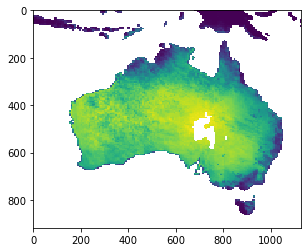

In [130]:
show(FWI)

### Create latitude and longitude coordinates

In [131]:
bounds = list(air.bounds) #BoundingBox(left, bottom, right, top)
print(bounds)
shape = list(air.shape) #longitude, latitude
print(shape)

[106.36052963975135, -46.173405603743404, 157.02551166409236, -4.9856498268633445]
[917, 1128]


In [132]:
# Define latitude
xlat = np.linspace(bounds[1],bounds[3], shape[0])
xlat.shape

(917,)

In [133]:
# Define longitude
ylon = np.linspace(bounds[0], bounds[2], shape[1])
ylon.shape

(1128,)

### Create an xarray Dataset

In [134]:
array = xr.DataArray(FireMask, [('lat', xlat), ('lon', ylon)])

In [135]:
ds = array.to_dataset(name = "firemask")

In [136]:
ds = ds.assign(MaxFRP = (('lat', 'lon'), MaxFRP))

# Veg bands
# ds = ds.assign(EVI = (('lat', 'lon'), EVI))
# ds = ds.assign(EVI2 = (('lat', 'lon'), EVI2))
# ds = ds.assign(NVDI = (('lat', 'lon'), NVDI))
# ds = ds.assign(NIR_reflectance = (('lat', 'lon'), NIR_reflectance))
# ds = ds.assign(SWIR1_reflectance = (('lat', 'lon'), SWIR1_reflectance))
# ds = ds.assign(SWIR2_reflectance = (('lat', 'lon'), SWIR2_reflectance))
# ds = ds.assign(SWIR3_reflectance = (('lat', 'lon'), SWIR3_reflectance))
# ds = ds.assign(VI_Quality = (('lat', 'lon'), VI_Quality))
# ds = ds.assign(blue_reflectance = (('lat', 'lon'), blue_reflectance))
# ds = ds.assign(composite_day_of_the_year = (('lat', 'lon'), composite_day_of_the_year))
# ds = ds.assign(green_reflectance = (('lat', 'lon'), green_reflectance))
# ds = ds.assign(pixel_reliability = (('lat', 'lon'), pixel_reliability))
# ds = ds.assign(red_reflectance = (('lat', 'lon'), red_reflectance))
# ds = ds.assign(relative_azimuth_angle = (('lat', 'lon'), relative_azimuth_angle))
# ds = ds.assign(sun_zenith_angle = (('lat', 'lon'), sun_zenith_angle))
# ds = ds.assign(view_zenith_angle = (('lat', 'lon'), view_zenith_angle))

# Precip bands
ds = ds.assign(gaugeQualityInfo = (('lat', 'lon'), gaugeQualityInfo))
ds = ds.assign(hourlyPrecipRate = (('lat', 'lon'), hourlyPrecipRate))
ds = ds.assign(hourlyPrecipRateGC = (('lat', 'lon'), hourlyPrecipRateGC))
ds = ds.assign(observationTimeFlag = (('lat', 'lon'), observationTimeFlag))
ds = ds.assign(satelliteInfoFlag = (('lat', 'lon'), satelliteInfoFlag))

# air bands
ds = ds.assign(Albedo_inst = (('lat', 'lon'), Albedo_inst))
ds = ds.assign(AvgSurfT_inst = (('lat', 'lon'), CanopInt_inst))
ds = ds.assign(CanopInt_inst = (('lat', 'lon'), CanopInt_inst))
ds = ds.assign(ECanop_tavg = (('lat', 'lon'), ECanop_tavg))
ds = ds.assign(ESoil_tavg = (('lat', 'lon'), ESoil_tavg))
ds = ds.assign(Evap_tavg = (('lat', 'lon'), Evap_tavg))
ds = ds.assign(LWdown_f_tavg = (('lat', 'lon'), LWdown_f_tavg))
ds = ds.assign(Lwnet_tavg = (('lat', 'lon'), Lwnet_tavg))
ds = ds.assign(PotEvap_tavg = (('lat', 'lon'), PotEvap_tavg))
ds = ds.assign(Psurf_f_inst = (('lat', 'lon'), Psurf_f_inst))
ds = ds.assign(Qair_f_inst = (('lat', 'lon'), Qair_f_inst))
ds = ds.assign(Qg_tavg = (('lat', 'lon'), Qg_tavg))
ds = ds.assign(Qh_tavg = (('lat', 'lon'), Qh_tavg))
ds = ds.assign(Qle_tavg = (('lat', 'lon'), Qle_tavg))
ds = ds.assign(Qs_acc = (('lat', 'lon'), Qs_acc))
ds = ds.assign(Qsb_acc = (('lat', 'lon'), Qsb_acc))
ds = ds.assign(Qsm_acc = (('lat', 'lon'), Qsm_acc))
ds = ds.assign(Rainf_f_tavg = (('lat', 'lon'), Rainf_f_tavg))
ds = ds.assign(RootMoist_inst = (('lat', 'lon'), RootMoist_inst))
ds = ds.assign(SWE_inst = (('lat', 'lon'), SWE_inst))
ds = ds.assign(SWdown_f_tavg = (('lat', 'lon'), SWdown_f_tavg))
ds = ds.assign(SnowDepth_inst = (('lat', 'lon'), SnowDepth_inst))
ds = ds.assign(Snowf_tavg = (('lat', 'lon'), Snowf_tavg))
ds = ds.assign(SoilMoi100_200cm_inst = (('lat', 'lon'), SoilMoi100_200cm_inst))
ds = ds.assign(SoilMoi10_40cm_inst = (('lat', 'lon'), SoilMoi10_40cm_inst))
ds = ds.assign(SoilMoi40_100cm_inst = (('lat', 'lon'), SoilMoi40_100cm_inst))
ds = ds.assign(SoilTMP0_10cm_inst = (('lat', 'lon'), SoilTMP0_10cm_inst))
ds = ds.assign(SoilMoi0_10cm_inst = (('lat', 'lon'), SoilMoi0_10cm_inst))
ds = ds.assign(SoilTMP100_200cm_inst = (('lat', 'lon'), SoilTMP100_200cm_inst))
ds = ds.assign(SoilTMP10_40cm_inst = (('lat', 'lon'), SoilTMP10_40cm_inst))
ds = ds.assign(SoilTMP40_100cm_inst = (('lat', 'lon'), SoilTMP40_100cm_inst))
ds = ds.assign(Swnet_tavg = (('lat', 'lon'), Swnet_tavg))
ds = ds.assign(Tair_f_inst = (('lat', 'lon'), Tair_f_inst))
ds = ds.assign(Tveg_tavg = (('lat', 'lon'), Tveg_tavg))
ds = ds.assign(Wind_f_inst = (('lat', 'lon'), Wind_f_inst))

# Burned
ds = ds.assign(BurnDate = (('lat', 'lon'), BurnDate))
ds = ds.assign(Uncertainty = (('lat', 'lon'), Uncertainty))
ds = ds.assign(QA = (('lat', 'lon'), QA))
ds = ds.assign(FirstDay = (('lat', 'lon'), FirstDay))
ds = ds.assign(LastDay = (('lat', 'lon'), LastDay))

# FWI
ds = ds.assign(FWI = (('lat', 'lon'), FWI))

### Convert to pandas dataframe

In [137]:
ds_df = ds.to_dataframe()
ds_df.reset_index(inplace = True)

In [138]:
# Flip lat column
ds_df["lat"] = ds_df["lat"].values[::-1]

In [139]:
ds_df.head()

,lat,lon,firemask,MaxFRP,gaugeQualityInfo,hourlyPrecipRate,hourlyPrecipRateGC,observationTimeFlag,satelliteInfoFlag,Albedo_inst,...,Swnet_tavg,Tair_f_inst,Tveg_tavg,Wind_f_inst,BurnDate,Uncertainty,QA,FirstDay,LastDay,FWI
0,-4.98565,106.360530,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,-4.98565,106.405485,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,-4.98565,106.450441,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,-4.98565,106.495396,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,-4.98565,106.540352,3.0,NaN,0.0,0.0,0.415,-1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [140]:
ds_df.to_parquet('../../finalproj_data/ds_df.parquet')